In [1]:
%env RANK=0
%env WORLD_SIZE=1
%env MASTER_ADDR=127.0.0.1
%env MASTER_PORT=2020

env: RANK=0
env: WORLD_SIZE=1
env: MASTER_ADDR=127.0.0.1
env: MASTER_PORT=2020


In [2]:
ckpt_dir = "modified_llama/llama-2-7b"
tokenizer_path = "modified_llama/tokenizer.model"
max_seq_len = 128
max_gen_len = 64
max_batch_size = 4

In [3]:
from modified_llama.llama import Llama
import torch

# Create the generator - very resource intensive
print("Building generator")
generator = Llama.build(
    ckpt_dir=ckpt_dir,
    tokenizer_path=tokenizer_path,
    max_seq_len=max_seq_len,
    max_batch_size=max_batch_size,
)
print("Built generator")

Building generator
> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


/home/ubuntu/.local/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Loaded in 11.63 seconds
Built generator


In [135]:
#QUERY1 = "The eighth and farthest known planet from the Sun is Neptune."
QUERY1 = "happiness"
QUERY2 = "water"
#QUERY2 = "Neptune is the farthest known and eighth planet from the Sun."
#QUERY2 = "The Roman god of freshwater and the sea in Roman religion is Poseidon."
#QUERY2 = "Colorado Springs is a city in and the county seat of El Paso County, Colorado, United States."

In [136]:
tokens = generator.tokenize(max_seq_len, [("", QUERY1), ("", QUERY2)], False, False)
raw_embeds, key_values, context_vectors = generator.generate(
    [toks for _, toks in tokens],
    max_gen_len
)

In [137]:
for _, t in tokens:
    print([generator.tokenizer.decode(i) for i in t])

['happiness']
['water']


In [138]:
query_raw_embeds = []
query_key_values = []
query_context_vectors = []
for i in range(len(context_vectors[0])):
    new_kv = []
    new_cv = []
    for j in range(len(context_vectors)):
        tensor = torch.tensor(context_vectors[j][i])
        tensor = tensor.flatten()
        new_cv.append(tensor)

        tensor = torch.tensor(key_values[j][i])
        tensor = tensor.flatten()
        new_kv.append(tensor)

    tensor = torch.tensor(raw_embeds[i])
    tensor = tensor.flatten()

    query_raw_embeds.append(tensor)
    query_key_values.append(new_kv)
    query_context_vectors.append(new_cv)

In [139]:
query_context_vectors = torch.stack([
    torch.stack([i for i in q])
    for q in query_context_vectors
])
cv_mean = query_context_vectors.mean(1, keepdim=True)
cv_std = query_context_vectors.std(1, keepdim = True) + 1e-3
query_context_vectors = (query_context_vectors - cv_mean) / cv_std

In [140]:
import statistics
from torch import nn

def find_sims(vectors, sim_scorer):
    similarities = [
        sim_scorer(vectors[0][i], vectors[1][i])
        for i in range(len(query_context_vectors[0]))
    ]

    min_idx, min_sim = min(enumerate(similarities), key=lambda s: s[1])
    max_idx, max_sim = max(enumerate(similarities), key=lambda s: s[1])
    avg_sim = sum(similarities) / len(similarities)
    med_sim = statistics.median(similarities)

    print(f"\tMin similarity of {min_sim} found in block #{min_idx}")
    print(f"\tMax similarity of {max_sim} found in block #{max_idx}")
    print(f"\tAvg similarity: {avg_sim}")
    print(f"\tMedian similarity: {med_sim}")

sim_scorer = nn.CosineSimilarity(dim=0)
embedding_sim = sim_scorer(query_raw_embeds[0], query_raw_embeds[1])

print("Stats for context vectors:")
find_sims(query_context_vectors, sim_scorer)
print()
print("Stats for key-value vectors:")
find_sims(query_key_values, sim_scorer)
print()
print(f"Similarity for raw embedding vectors: {embedding_sim}")

Stats for context vectors:
	Min similarity of 0.5966796875 found in block #1
	Max similarity of 0.99609375 found in block #10
	Avg similarity: 0.96484375
	Median similarity: 0.98974609375

Stats for key-value vectors:
	Min similarity of 0.9150390625 found in block #1
	Max similarity of 1.0 found in block #4
	Avg similarity: 0.99609375
	Median similarity: 0.99951171875

Similarity for raw embedding vectors: 0.05328369140625


tensor(-96.3125)
tensor(62.1562)
tensor(-0.0024)


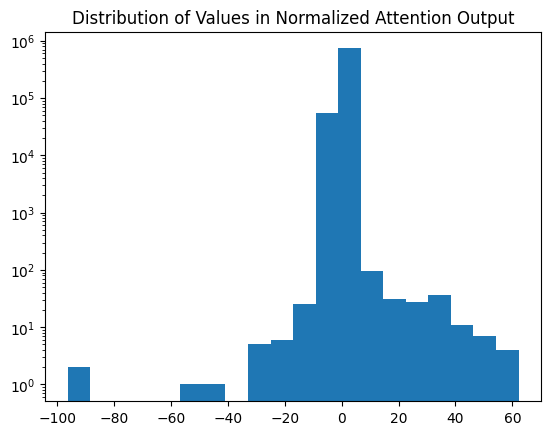

In [81]:
import matplotlib.pyplot as plt

total = torch.stack([
    torch.stack([i for i in q])
    for q in query_context_vectors
])
total = (total - total.mean(2, keepdim=True)) / (total.std(2, keepdim = True) + 1e-3)

print(total.min())
print(total.max())
print(total.median())

plt.hist(total.flatten().cpu(), 20, log=True)
plt.title("Distribution of Values in Normalized Attention Output")
plt.show()